## Imports

In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.stats import norm
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt 

## Consts

In [2]:
quantile = 0.5

## Methods

In [3]:
def load_df(X, Y, imputer, based_on:str = None, plot = True):
    assert (not plot) or (based_on is not None), "To plot, based on should not be None"
    data_df = pd.read_csv("cleaned-dataset.csv")
    districts_df = pd.read_csv("districts.csv", index_col=0)
    df = data_df.join(districts_df, on='ID')
    df = pd.get_dummies(df, columns=["District"])
    df = df[df.JEWISH == 1]
    
    if based_on is not None:
        df['T'] = (df[based_on] > df[based_on].quantile(quantile))
        
        imputed = imputer.fit_transform(df[X + [Y]])
        df[X + [Y]] = imputed
        
    if plot:
        plt.hist(df[df['T'] == True][Y], alpha = 0.5, label='T = True')
        plt.hist(df[df['T'] == False][Y], alpha = 0.5, label = 'T = False')
        plt.ylabel('count')
        plt.xlabel(Y)
        plt.legend()
        plt.show()
    return df

## Bootstrapper

In [4]:
def bootstrap(func, sampler, B = 500, alpha = 0.05):
    samples = [func(*sampler()) for _ in range(B)]
    return np.quantile(samples, [alpha/2, 1-alpha/2])


## Wilcoxon
To check if there is a real difference between the groups

In [5]:
def wilcoxon(df, based_on, verbose=True):
    sorted_df = df.copy().sort_values(based_on).reset_index(drop=True)
    sorted_df.index += 1 # start index with 1 and not 0

    # consts in the test
    n = len(sorted_df[sorted_df['T'] == True])
    N = len(sorted_df)
    m = N-n

    # expectation and variance
    expected = n*(N + 1) / 2
    var = m*n*(N+1) / 12

    # test statistics
    W_S = sum(sorted_df[sorted_df['T'] == True].index)
    T = (W_S - expected) / (var)**0.5
    Z_alpha = norm.ppf(0.95)

    if verbose:
        if T > Z_alpha:
            print("Samples with T = True are statistically bigger")
        elif T < -Z_alpha:
            print("Samples with T = True are statistically smaller")

## Matching

In [6]:
def calc_ate_matching(df, X, Y, p=1, k = 1) -> float:
    df = df.copy()
    treated = df[df['T'] == True].reset_index(drop=True)
    untreated = df[df['T'] == False].reset_index(drop=True)
    
    df[X] = df[X]/df[X].std() # normalize the data
    # predict on treated
    model = KNeighborsRegressor(k, p=p).fit(untreated[X], untreated[Y])
    preds_treated = model.predict(treated[X])
    diff1 = treated[Y] - preds_treated

    # prdict on untreated
    model = KNeighborsRegressor(k, p=p).fit(treated[X], treated[Y])
    preds_untreated = model.predict(untreated[X])
    diff2 = preds_untreated - untreated[Y]

    all_diff = np.concatenate([diff1, diff2])
    return np.mean(all_diff)   

## IPW

In [7]:
def calc_ate_ipw(df, X, Y, regression, return_prop=False):
    df = df.copy()
    model = regression.fit(df[X], df["T"])
    treated = df[df['T'] == True].reset_index(drop=True)
    untreated = df[df['T'] == False].reset_index(drop=True)
    
    propensity_treated = model.predict_proba(treated[X]).T[1]
    propensity_untreated = model.predict_proba(untreated[X]).T[1]

    # first sum
    sum1 = (treated[Y] / propensity_treated).sum()

    # second sum
    sum2 = (untreated[Y] / (1 - propensity_untreated)).sum()
    if return_prop:
        return (sum1 - sum2)/len(df['T']), (propensity_treated, propensity_untreated)
    return (sum1 - sum2)/len(df['T'])

## T-learner

In [8]:
def calc_ate_t_learner(df, X, Y, treated_regression, control_regression):
    df = df.copy()
    treated = df[df["T"] == True].reset_index(drop=True)
    control = df[df["T"] == False].reset_index(drop=True)
    treated_model =  treated_regression.fit(treated[X], treated[Y])
    control_model =  control_regression.fit(control[X], control[Y])
    ate = treated_model.predict(df[X]) - control_model.predict(df[X])
    return np.mean(ate)

## S learner

In [9]:
def calc_ate_s_learner(df, X, Y, regression, based_on:str=None, use_original:bool=False):  
    assert not use_original or based_on is not None
    df = df.copy().dropna()
    if use_original:
        features = X + [based_on]
    else:
        features = X + ['T']
    
    model = regression.fit(df[features], df[Y])
    
    # untreated
    if use_original:
        pass # stays the same
    else:
        df['T'] = False
    untreated_preds = model.predict(df[features])

    # treated
    if use_original:
        df[based_on] = 1.1 * df[based_on]
    else:
        df['T'] = True
    treated_preds = model.predict(df[features])
    
    return np.mean(treated_preds - untreated_preds)

In [10]:
def all_models(X, Y, based_on, B = 500):
    X = X.copy() # prep
    X.remove(based_on)
    cleaned_df = load_df(X, Y, SimpleImputer(strategy='mean'), based_on = based_on, plot=False) # load the dataset
    wilcoxon(cleaned_df, based_on) # wilcoxon

    # matching
    matching_CI = bootstrap(lambda df: calc_ate_matching(df, X, Y, k = 3), lambda : (cleaned_df.sample(frac = 1, replace=True),), B)
    matching_all = calc_ate_matching(cleaned_df, X, Y, k = 3)
    print(f"Matching : True value - {matching_all}, CI - {matching_CI}")
    
    # IPW
    ipw_CI = bootstrap(lambda df: calc_ate_ipw(df, X, Y, LogisticRegression(solver='liblinear')), \
                    lambda : (cleaned_df.sample(frac = 1, replace=True),), B)
    ipw_all, (propensity_treated, propensity_untreated) = calc_ate_ipw(cleaned_df, X, Y, LogisticRegression(solver='liblinear'), return_prop=True)
    print(f"IPW : True value - {ipw_all}, CI - {ipw_CI}")

    # T learner 
    t_learner_CI = bootstrap(lambda df: calc_ate_t_learner(df, X, Y, DecisionTreeRegressor(), DecisionTreeRegressor()),\
                           lambda : (cleaned_df.sample(frac = 1, replace=True),), B)
    t_learner_all = calc_ate_t_learner(cleaned_df, X, Y, DecisionTreeRegressor(), DecisionTreeRegressor())
    print(f"T Learner : True value - {t_learner_all}, CI - {t_learner_CI}")
    
    # S Learner
    s_learner_CI = bootstrap(lambda df: calc_ate_s_learner(df, X, Y, DecisionTreeRegressor(), use_original=False),\
                           lambda : (cleaned_df.sample(frac = 1, replace=True),), B)
    s_learner_all = calc_ate_s_learner(cleaned_df, X, Y, DecisionTreeRegressor(), use_original=False)
    print(f"S Learner : True value - {s_learner_all}, CI - {s_learner_CI}")
    return (matching_CI, matching_all), (ipw_CI, ipw_all), (t_learner_CI, t_learner_all), (s_learner_CI, s_learner_all), (propensity_treated, propensity_untreated)


In [11]:
def plot_CI(Y, based_on, **kwargs):
    plt.title(f"Confidence interval for {Y} based on {based_on}")
    for index, ((low, high), value_all) in enumerate(kwargs.values()):
        plt.plot([index, index], [low, high], color = 'b')
        plt.plot([index-0.25, index+0.25], [high, high], color = 'b')
        plt.plot([index-0.25, index+0.25], [low, low], color = 'b')
        plt.plot(index, value_all, 'o', color = 'red')
    plt.xticks(range(len(kwargs)), kwargs.keys())
    plt.show()

# Practical part

In [12]:
df = pd.read_csv("cleaned-dataset.csv")
districts_df = pd.read_csv("districts.csv", index_col=0)
districts_df
df = df.join(districts_df, on='ID')
full_dataset = pd.get_dummies(df, columns=["District"])
full_dataset

,RASHUT,ID,SES,PERIPH,JEWISH,YEAR,DIST_FROM_TLV,JEWS_PERCENT,Teachers-skills,immigrant,...,Class-size,Teacher-student-ratio,ALLOCATION_LOG,District_Center,District_Haifa,District_Jerusalem,District_Tel Aviv,District_Yehuda and Shomron,District_north,District_south
0,אבו גוש,1,2,6,0,2014,41.6,0.0,19.0,0.0,...,25.0,8.0,7.425358,0,0,1,0,0,0,0
1,אבו גוש,1,3,6,0,2015,41.6,0.0,22.0,0.0,...,25.0,8.0,7.730614,0,0,1,0,0,0,0
2,אבו גוש,1,3,6,0,2016,41.0,0.0,21.0,0.0,...,25.0,8.0,8.282483,0,0,1,0,0,0,0
3,אבו גוש,1,3,6,0,2017,41.0,0.0,22.0,0.0,...,25.0,7.0,8.231376,0,0,1,0,0,0,0
4,אבו גוש,1,3,6,0,2018,41.0,0.0,34.0,0.0,...,24.0,7.0,8.254009,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,תמר,255,6,2,1,2016,NaN,91.1,42.0,4.0,...,16.0,5.0,10.751200,0,0,0,0,0,0,1
1781,תמר,255,6,2,1,2017,NaN,91.1,38.0,4.0,...,15.0,5.0,10.756434,0,0,0,0,0,0,1
1782,תמר,255,6,2,1,2018,NaN,90.1,46.0,1.0,...,18.0,5.0,10.780954,0,0,0,0,0,0,1
1783,תמר,255,7,2,1,2019,NaN,90.2,42.0,1.0,...,19.0,5.0,10.892564,0,0,0,0,0,0,1


In [13]:
Y_values = ["Matriculation-eligibility", "Excellent-matriculation-eligibility", "Math"]
X = [col for col in full_dataset if (col not in Y_values and col not in ["RASHUT", "ID"])]
print(f"X = {X} \n\nPossible value for Y are {Y_values}")

X = ['SES', 'PERIPH', 'JEWISH', 'YEAR', 'DIST_FROM_TLV', 'JEWS_PERCENT', 'Teachers-skills', 'immigrant', 'Special-Education', 'Class-size', 'Teacher-student-ratio', 'ALLOCATION_LOG', 'District_Center', 'District_Haifa', 'District_Jerusalem', 'District_Tel Aviv', 'District_Yehuda and Shomron', 'District_north', 'District_south'] 

Possible value for Y are ['Matriculation-eligibility', 'Excellent-matriculation-eligibility', 'Math']


## ATE calculations

Y = Matriculation-eligibility, based on = SES
Samples with T = True are statistically bigger
Matching : True value - 4.704445646850139, CI - [3.27439023 6.41682095]
IPW : True value - 14.679279227314344, CI - [ -4.3171214  105.53465328]
T Learner : True value - 5.1355386998133525, CI - [0.70703376 7.4252505 ]
S Learner : True value - 3.6814595660749507, CI - [-0.58264558  5.51774892]


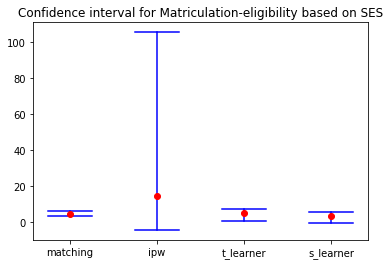


Y = Matriculation-eligibility, based on = ALLOCATION_LOG
Samples with T = True are statistically bigger
Matching : True value - -1.235740737063658, CI - [-2.4841233   0.13120952]
IPW : True value - -6.498522745446945, CI - [-9.94287746 -2.79961235]
T Learner : True value - -1.7957909733529214, CI - [-4.44682871  0.59950477]
S Learner : True value - -0.8425742574257425, CI - [-2.57885729  0.59436646]


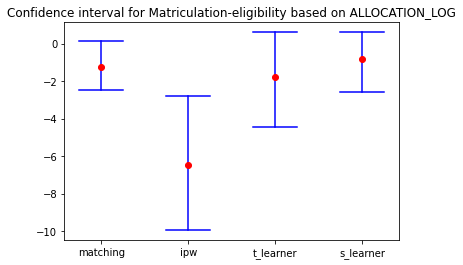


Y = Matriculation-eligibility, based on = Teachers-skills
Samples with T = True are statistically bigger
Matching : True value - 7.4813839468911745, CI - [6.1640032  9.28863102]
IPW : True value - 10.96096183466538, CI - [ 5.59401219 18.71410536]
T Learner : True value - 7.983750148921804, CI - [2.33345206 8.99670033]
S Learner : True value - 5.988165680473373, CI - [-0.57085541  8.39686883]


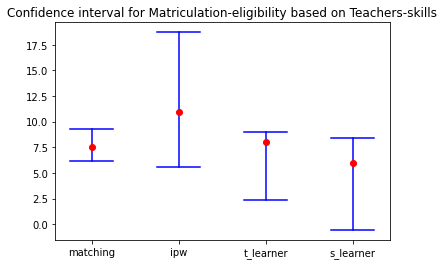


Y = Excellent-matriculation-eligibility, based on = SES
Samples with T = True are statistically bigger
Matching : True value - 1.9545520983634044, CI - [1.07546814 3.1027727 ]
IPW : True value - 2.943121975599607, CI - [-0.38567918 11.01673476]
T Learner : True value - 2.2451931350356755, CI - [-0.20453579  3.31354481]
S Learner : True value - 0.41321499013806706, CI - [-1.95773121  3.53440579]


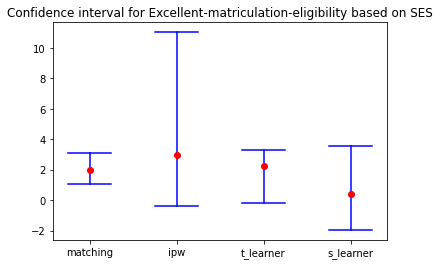


Y = Excellent-matriculation-eligibility, based on = ALLOCATION_LOG
Samples with T = True are statistically bigger
Matching : True value - -1.0828201046644514, CI - [-1.79525684 -0.33441116]
IPW : True value - -2.1908077681939235, CI - [-2.92559803 -1.20206418]
T Learner : True value - -1.476649888143176, CI - [-2.46527772 -0.59466874]
S Learner : True value - -0.29306930693069305, CI - [-0.86138053  0.25075594]


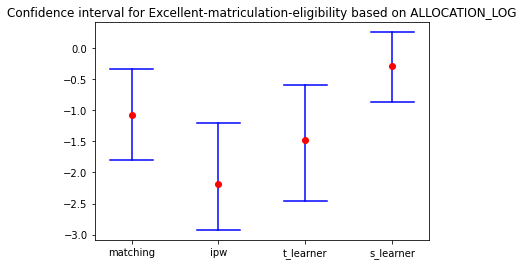


Y = Excellent-matriculation-eligibility, based on = Teachers-skills
Samples with T = True are statistically bigger
Matching : True value - 2.539666977747773, CI - [2.01458623 3.27224578]
IPW : True value - 3.482461660676188, CI - [2.34410105 5.86914723]
T Learner : True value - 2.0853950730047783, CI - [1.4327871  3.78097147]
S Learner : True value - 2.9842209072978303, CI - [0.09849765 3.56438477]


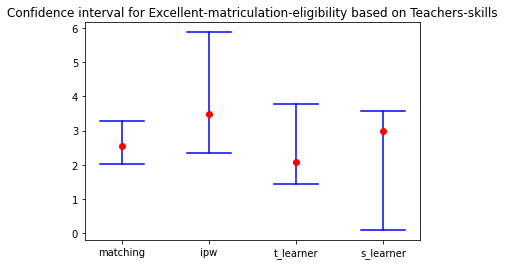


Y = Math, based on = SES
Samples with T = True are statistically bigger
Matching : True value - 4.540411862559513, CI - [3.73179279 5.52382748]
IPW : True value - 6.4346333400693, CI - [ 2.23724763 21.89320219]
T Learner : True value - 4.422797281018758, CI - [1.49067985 5.69899006]
S Learner : True value - 2.116370808678501, CI - [0.83567395 6.57312551]


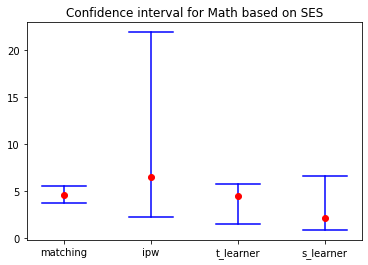


Y = Math, based on = ALLOCATION_LOG
Samples with T = True are statistically bigger
Matching : True value - -1.5525010038432856, CI - [-2.35557653 -0.59311955]
IPW : True value - -2.898765870940834, CI - [-3.80970324 -1.70520972]
T Learner : True value - -1.5089055240061957, CI - [-3.61221982 -1.13993719]
S Learner : True value - -0.6138613861386139, CI - [-1.25924284  0.12355382]


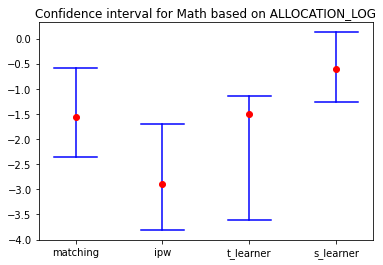


Y = Math, based on = Teachers-skills
Samples with T = True are statistically bigger
Matching : True value - 4.698933057993461, CI - [4.21704275 5.58639954]
IPW : True value - 5.2907078948129715, CI - [4.14999919 8.55398656]
T Learner : True value - 3.535450008604371, CI - [2.38550755 4.72085484]
S Learner : True value - 1.868836291913215, CI - [0.533867  4.8451776]


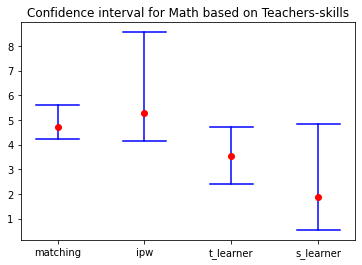

In [14]:
propensity_dict = {}
for Y in Y_values:
    for based_on in 'SES', "ALLOCATION_LOG", "Teachers-skills":
        print(f"Y = {Y}, based on = {based_on}")
        matching, ipw, t_learner, s_learner, propensities = all_models(X, Y, based_on, B=200)
        plot_CI(Y, based_on, matching = matching, ipw = ipw, t_learner = t_learner, s_learner = s_learner)
        propensity_dict[(Y, based_on)] = propensities
        print()

## Graphs for added 'based on'

In [31]:
def plot_graph_multiply(X:list, Y:str, regression, based_on:str, df: pd.DataFrame=None) -> None:  
    # copy so nothing will be harmed
    X = X.copy()
    if df is None:
        df = load_df(X, Y, SimpleImputer(strategy="mean"), based_on, plot=False)
    else:
        df = df.copy()

    if based_on in X:
        X.remove(based_on)
    
    features = X + [based_on]
    model = regression.fit(df[features], df[Y]) # fit model

    # predict for each alpha
    all_means = []
    all_CI_low, all_CI_high = [], []
    values = np.arange(0, 2, 0.1)

    original_prediction_mean = model.predict(df[features]).mean()
    original_based_on = np.array(df[based_on])
    for alpha in values:
        df[based_on] = alpha * original_based_on # change the values
        alpha_preds = model.predict(df[features]) # predict again
        
        all_means.append(alpha_preds.mean()- original_prediction_mean) 
        # use bootstrap for CI
        low, high = bootstrap(lambda sample_df: model.predict(sample_df[features]).mean() - original_prediction_mean, lambda : (df.sample(frac=1, replace=True),), 40) 
        all_CI_low.append(low)
        all_CI_high.append(high)
    
    # plot
    plt.title(fr"ATE of '{Y}' for $\alpha \cdot $'{based_on}'" +"\n"+ fr"$\alpha \in [0, 2]$. confidence interval of 95%")
    plt.ylabel(f"Prediction on {Y}")
    plt.xlabel(r"$\alpha$")
    plt.plot(values, all_means)
    plt.fill_between(values, all_CI_low, all_CI_high, alpha=0.5)
    plt.show()

In [32]:
def plot_graph_set_values(X:list, Y:str, regression, based_on:str, df: pd.DataFrame = None) -> None:  
    # copy so nothing will be harmed
    X = X.copy()
    if df is None:
        df = load_df(X, Y, SimpleImputer(strategy="mean"), based_on, plot=False)
    else:
        df = df.copy()

    if based_on in X:
        X.remove(based_on)
    
    features = X + [based_on]
    model = regression.fit(df[features], df[Y]) # fit model

    # predict for each alpha
    all_means = []
    all_CI_low, all_CI_high = [], []

    max_val = df[based_on].max()
    values = np.linspace(0, 1.5*max_val, 90)

    # control value
    df[based_on] = 0
    control_prediction_mean = model.predict(df[features]).mean()

    for alpha in values:
        df[based_on] = alpha # change the values
        alpha_preds = model.predict(df[features]) # predict again
        all_means.append(alpha_preds.mean() - control_prediction_mean) 

        # use bootstrap for CI
        low, high = bootstrap(lambda sample_df: model.predict(sample_df[features]).mean() - control_prediction_mean, \
                              lambda : (df.sample(frac=1, replace=True),), 40) 
        all_CI_low.append(low)
        all_CI_high.append(high)
    
    # plot
    plt.title(fr"ATE of '{Y}' for {based_on} = $\alpha$;"+ "\n"+ fr"$\alpha \in [0, 1.5 \cdot \max$ ({based_on})], confidence interval for 95%")
    plt.ylabel(f"Prediction on {Y}")
    plt.xlabel(r"$\alpha$")
    plt.plot(values, all_means)
    plt.fill_between(values, all_CI_low, all_CI_high, alpha=0.5)
    plt.show()

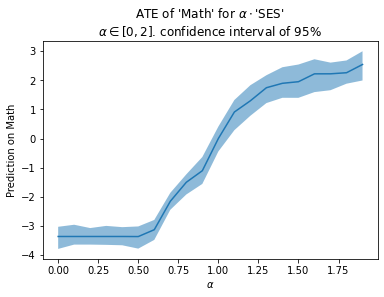

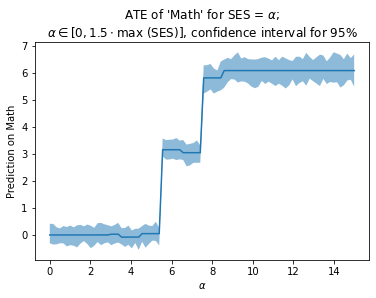

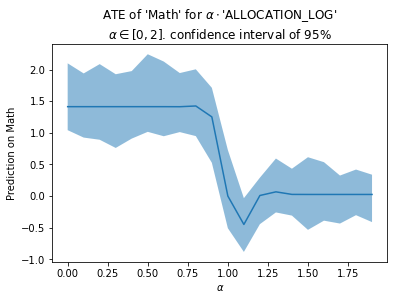

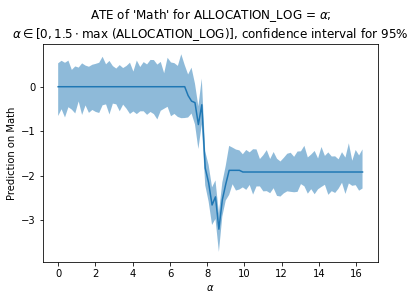

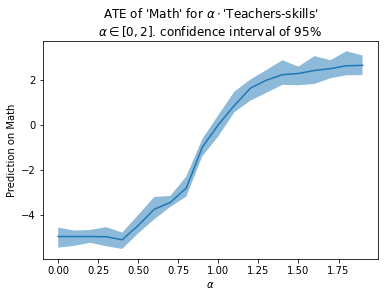

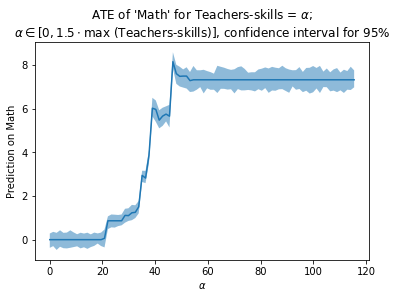

In [34]:
for Y in ["Math"]:
    for based_on in 'SES', "ALLOCATION_LOG", "Teachers-skills":
        plot_graph_multiply(X, Y, DecisionTreeRegressor(), based_on)
        plot_graph_set_values(X, Y, DecisionTreeRegressor(), based_on)

## Common support

In [18]:
def plot_commom_support(propensity_dict):
    for (Y, based_on), (propensity_treated, propensity_untreated) in propensity_dict.items():
        plt.title(f"Common support for {Y} based on {based_on}")
        plt.hist(propensity_treated, alpha=0.5, label="Treated")
        plt.hist(propensity_untreated, alpha=0.5, label="Untreated")
        plt.legend()
        plt.xlabel(r"$P(T=1|X)$")
        plt.ylabel("count")
        plt.show()

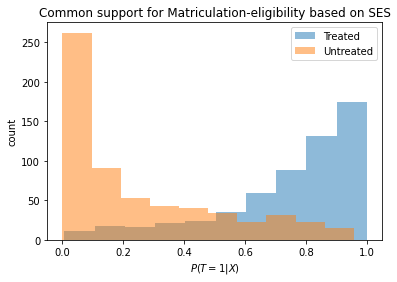

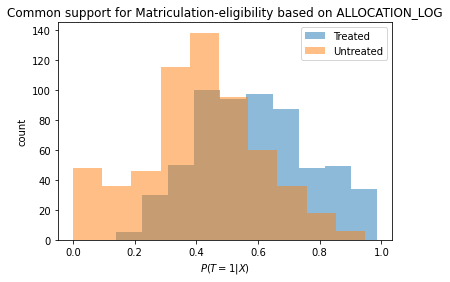

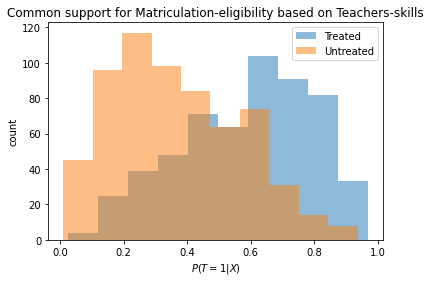

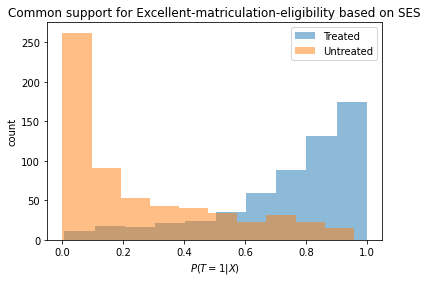

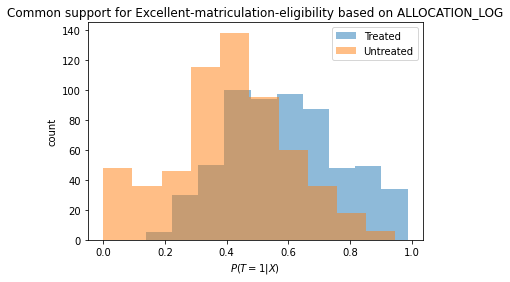

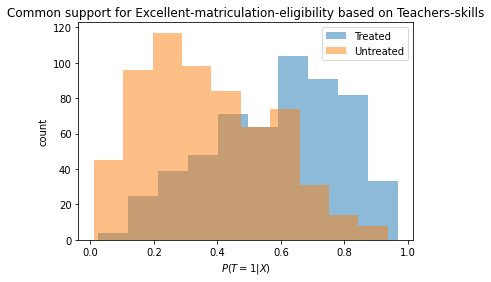

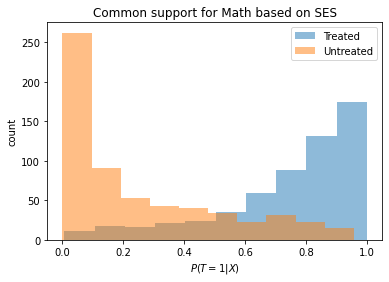

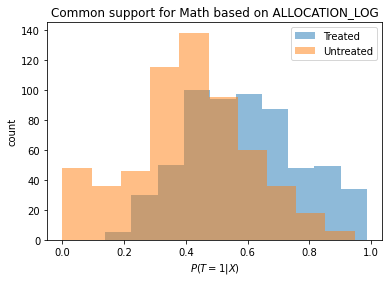

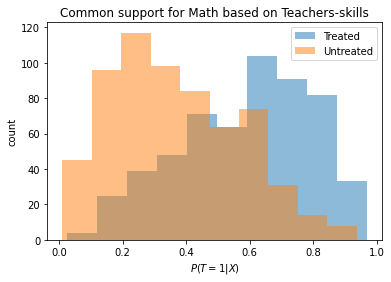

In [19]:
plot_commom_support(propensity_dict)